In [12]:
# Necessary Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from datetime import datetime
from datetime import timezone
from dateutil import parser
from pathlib import Path

In [3]:
# Importing the youtube data
file_path = r"C:\Users\...\youtube_data_4K_channels.csv" #choose your own file path
df = pd.read_csv(file_path)

In [4]:
# quick info on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   channel_id                4260 non-null   object 
 1   channel_title             4260 non-null   object 
 2   niche                     4260 non-null   object 
 3   start_date                4260 non-null   object 
 4   current_subscriber_count  4260 non-null   int64  
 5   years_active              4260 non-null   int64  
 6   channel_age_days          4260 non-null   int64  
 7   total_videos              4260 non-null   int64  
 8   avg_views                 4260 non-null   float64
 9   avg_likes                 4260 non-null   float64
 10  avg_comments              4260 non-null   float64
 11  uploads_per_week          4260 non-null   int64  
 12  reached_250k              4260 non-null   bool   
 13  time_to_250k_days         68 non-null     float64
 14  growth_r

In [5]:
# Constructing an mc simulation function
def monte_carlo_probability(
    df: pd.DataFrame,
    horizon_days: int = 365 * 3,
    sims: int = 5000,
    variability_ratio: float = 0.25,
    use_lognormal: bool = False,
    random_state: int | None = 42
) -> pd.DataFrame:
    
    """
    Vectorized Monte Carlo simulation of subscriber growth.
    Returns a DataFrame with per-channel probabilities and summary stats.
    
    Parameters:
    - variability_ratio: scales std around mean daily growth (e.g., 0.25 -> 25% of mean).
    - use_lognormal: if True, model daily gains as Lognormal; else Gaussian with floor at 0.
    """
    
    rng = np.random.default_rng(random_state)

    channels = df["channel_id"].to_numpy()
    current = df["current_subscriber_count"].to_numpy(dtype=float)
    mean_growth = df["growth_rate_per_day"].to_numpy(dtype=float)

    # Scale variability by engagement and uploads for richer dynamics
    engagement = np.clip(df["engagement_rate"].to_numpy(dtype=float), 0, None)
    uploads = np.clip(df["uploads_per_week"].to_numpy(dtype=float), 0.01, None)
    
    # Normalized modifiers
    eng_mod = 1.0 + 0.5 * (engagement / (engagement.mean() + 1e-9))
    upl_mod = 1.0 + 0.3 * (uploads / (uploads.mean() + 1e-9))

    std_growth = np.clip(mean_growth * variability_ratio * eng_mod * upl_mod, 0.0, None)

    n = len(channels)
    
    # Shape: (n_channels, sims, horizon_days)
    if use_lognormal:
        # Lognormal params from mean and std (approximation)
        mu = np.log(np.clip(mean_growth, 1e-6, None)) - 0.5 * np.log1p((std_growth / np.clip(mean_growth, 1e-6, None)) ** 2)
        sigma = np.sqrt(np.log1p((std_growth / np.clip(mean_growth, 1e-6, None)) ** 2))
        daily = rng.lognormal(mean=mu[:, None, None], sigma=sigma[:, None, None], size=(n, sims, horizon_days))
    else:
        daily = rng.normal(loc=mean_growth[:, None, None], scale=std_growth[:, None, None], size=(n, sims, horizon_days))
        daily = np.clip(daily, 0.0, None)

    cumulative_gains = daily.sum(axis=2)  # (n, sims)
    ending_subs = current[:, None] + cumulative_gains
    hit_250k = ending_subs >= 250_000

    prob = hit_250k.mean(axis=1)
    
    # Expected days to hit 250k (median over successful paths); fallback to NaN if never hit
    # Compute first passage time for each sim:
    threshold = 250_000 - current[:, None]
    cum_daily = daily.cumsum(axis=2)  # (n, sims, t)
    reached = cum_daily >= threshold[:, :, None]  # bool
    
    # For each channel, sim: first time index reaching threshold
    first_hit_idx = reached.argmax(axis=2)  # returns 0 if never reached; need mask
    ever_hit = reached.any(axis=2)
    
    # Days to hit (1-based indexing for day count)
    days_to_hit = np.where(ever_hit, first_hit_idx + 1, np.nan)
    
    # Median across sims per channel
    median_days_to_hit = np.nanmedian(days_to_hit, axis=1)

    # Expected ending subs and quantiles
    expected_end = ending_subs.mean(axis=1)
    q10 = np.quantile(ending_subs, 0.10, axis=1)
    q50 = np.quantile(ending_subs, 0.50, axis=1)
    q90 = np.quantile(ending_subs, 0.90, axis=1)

    out = pd.DataFrame({
        "channel_id": channels,
        "prob_250k_in_horizon": prob,
        "median_days_to_250k": median_days_to_hit,
        "expected_end_subs": expected_end,
        "end_subs_q10": q10,
        "end_subs_q50": q50,
        "end_subs_q90": q90,
        "horizon_days": horizon_days,
        "sims": sims
    })
    return out

In [6]:
# Running the simulation
sim_df = monte_carlo_probability(df, horizon_days=365*3, sims=500, variability_ratio=0.25, use_lognormal=False)

C:\Users\External Boot\AppData\Local\Temp\ipykernel_3332\1163709026.py:68: RuntimeWarning: All-NaN slice encountered
  median_days_to_hit = np.nanmedian(days_to_hit, axis=1)


In [7]:
# Quick check on the dataframe
sim_df.head()

,channel_id,prob_250k_in_horizon,median_days_to_250k,expected_end_subs,end_subs_q10,end_subs_q50,end_subs_q90,horizon_days,sims
0,UCL00BrVUCrD18WW-7o1FcUA,0.0,NaN,0.000000,0.000000,0.000000,0.000000,1095,500
1,UC1FeEGVBm-oP3ZaWmq5defw,0.0,NaN,0.000000,0.000000,0.000000,0.000000,1095,500
2,UCJye8fiTOm49_753oTeCZdQ,0.0,NaN,149.535237,149.074780,149.520707,150.020578,1095,500
3,UCjx0RwSAWLxtyfjhiZ-71DA,0.0,NaN,0.000000,0.000000,0.000000,0.000000,1095,500
4,UC8EsxeKeno8y6MZGjUDBPZw,0.0,NaN,3.228668,3.196142,3.228570,3.261008,1095,500


In [8]:
# Quick check on the dataframe info
sim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260 entries, 0 to 4259
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   channel_id            4260 non-null   object 
 1   prob_250k_in_horizon  4260 non-null   float64
 2   median_days_to_250k   108 non-null    float64
 3   expected_end_subs     4260 non-null   float64
 4   end_subs_q10          4260 non-null   float64
 5   end_subs_q50          4260 non-null   float64
 6   end_subs_q90          4260 non-null   float64
 7   horizon_days          4260 non-null   int64  
 8   sims                  4260 non-null   int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 299.7+ KB


In [9]:
# Quick description of prob_250k_in_horizon
sim_df['prob_250k_in_horizon'].describe()

count    4260.000000
mean        0.025219
std         0.156624
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prob_250k_in_horizon, dtype: float64

<Axes: xlabel='prob_250k_in_horizon', ylabel='Count'>

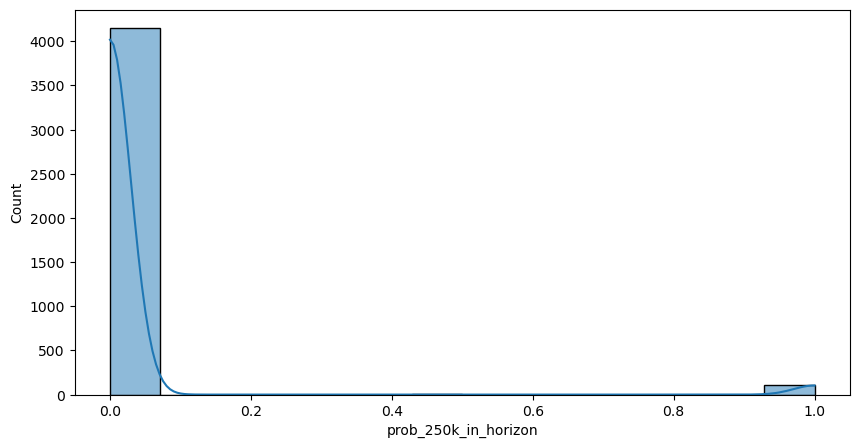

In [15]:
# Quick check on the histplot for distribution check
plt.figure(figsize=(10,5))
sns.histplot(sim_df['prob_250k_in_horizon'], kde=True)

In [ ]:
# Saving the results as a dataframe 
output_dir = Path('C:/Users/.../YT Analysis Data') #choose your own file path
output_filename = 'monte_carlo_simulation_data.csv'
output_filepath = output_dir/output_filename
print(output_filepath)

# Creating the directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Saving the DataFrame to CSV in the new location
sim_df.to_csv(output_filepath, index=False)
print("Channels Saved Succesfully!")